<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Part_2/Stable_Diffusion_Deep_Dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Making the necessary imports needed

In [2]:
!pip install -q --upgrade transformers diffusers ftfy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.4 MB/s eta 0:00:00


In [4]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Loading the models 

The below code will download and setup the relevant models and components we'll be needing. 

In [5]:
# Putting all these models to train and work in the GPU
# Loading the auotencoder model which will be used to decode the latents into image space (Feature vec for image)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(torch_device) # subfolder vae 

# Load the tokenizer for the texts and the respective encoder 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)

# The Unet model we've discussed in prev lecture is been loaded here 
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "unet").to(torch_device)

# The noise scheduler to pick up the noise for each images
scheduler = LMSDiscreteScheduler(beta_start = 0.00085 , beta_end = 0.012 , 
                                 beta_schedule = "scaled_linear" , num_train_timesteps = 1000)




Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


### Diffusion Loop 

This is the loop which is adapted from the HF Noteboo and its from the `__call__` method of the stable diffusion pipeline. 

https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L200

For now we'll just copy paste the code and in letter section we will dig deep and unravel each component of the loop and put it together.

0it [00:00, ?it/s]

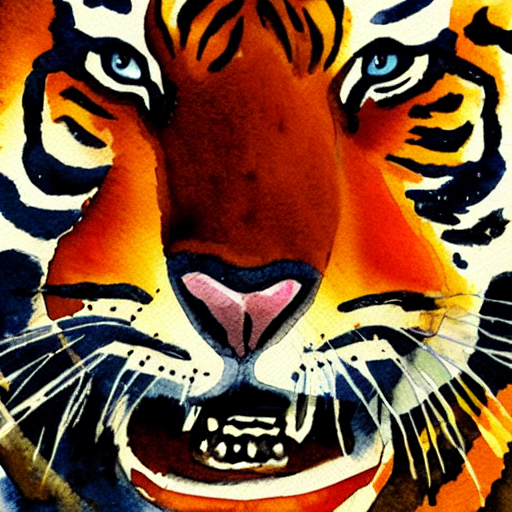

In [7]:
# Some settings
prompt = ["A watercolor painting of an very angry tiger"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

## The AutoEncoder (AE) 

AE can `encode` an image into some sort of latent representation and `decode` it back into an image. 

**Some Notes**
- It doesn't operate on pixels instead it operates on the latent space or other autoencoders (VAE specifically).
- The VAE is helps in compressing large number of imaages and compress them into latent.

Below is the code that will do what we've discussed above.

In [8]:
# From image to some latent 
# We use VAE to compress the image pixels to some sort of latents 

def pil_to_latent(input_im):

  with torch.no_grad():
    # Calling the encode on th etensor version of the image
    latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # 2-1 is the scaling
    # 0.18125 is the scaling factor used in the paper (author)
    # we sample from the distribution calculated
  return 0.18215 * latent.latent_dist.sample()

In [24]:
# From latents to image 
# Decode the latents to image 

def latents_to_pil(latents):
  # batch of latent -> list of images
  latents = (1 / 0.18215) * latents # reverse latent decoding / removing the scaling 
  with torch.no_grad():
    image = vae.decode(latents).sample # sample using the distribution

  # All things below is to retain the original pil image passed in
  image = (image / 2 + 0.5).clamp(0 , 1)
  image = image.detach().cpu().permute(0 , 2, 3, 1).numpy() 
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

In [10]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0   249k      0 --:--:-- --:--:-- --:--:--  249k


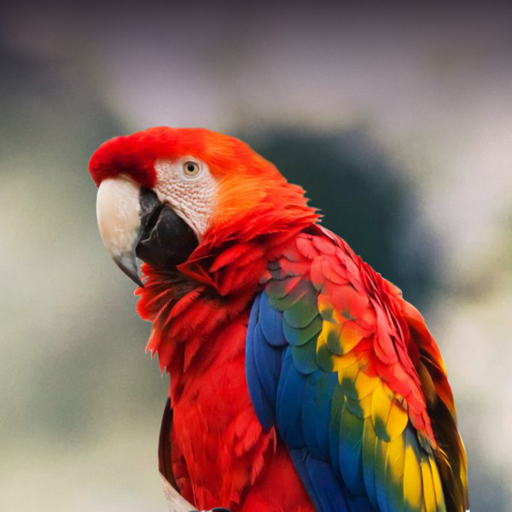

In [11]:
#  Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

Encode the image into latent space of the autoencoder with the function we've defined. 

In [12]:
encoded = pil_to_latent(input_image)
encoded.shape # shape of the latents

torch.Size([1, 4, 64, 64])

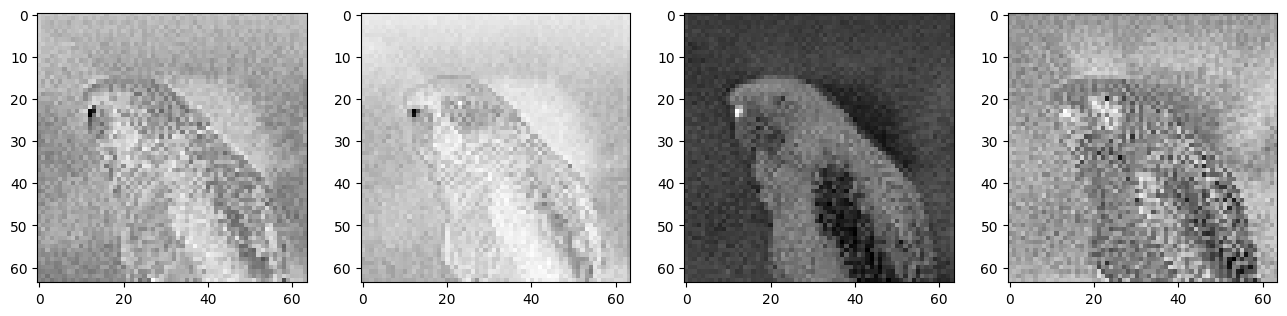

In [22]:
# Lets visualize the four channels for our image 
fig , axs = plt.subplots(1 , 4, figsize = (16 , 4))
for c in range(4):
  axs[c].imshow(encoded[0][c].cpu() , cmap = "Greys")

When we pass this into the decoder we get back something very close to our input image.

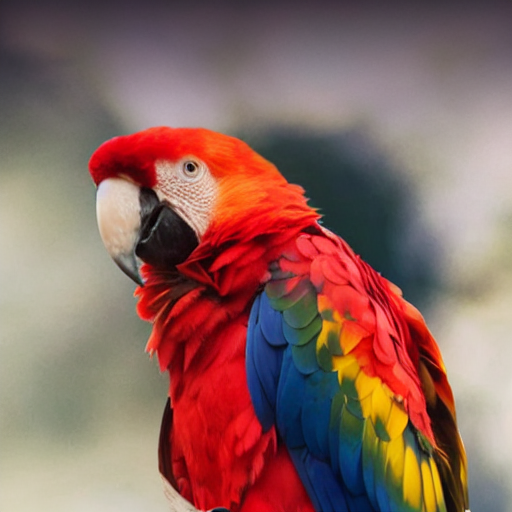

In [27]:
# Decode this latent representation back into an image 
decoded = latents_to_pil(encoded)[0] # [0] to get the image except the object
decoded

This autoencoder has been trained to squish down an image to a smaller representation and then re-create the image back from this compressed version again.

In this particular case the compression factor is 48, we start with a 3x512x512(chxhtxwd) image and it get compressed to a latent vector 4x64x64. Each 3x8x8 pixel volume in the input image gets compressed down to just 4 numbers(4x1x1). You can find AEs with a higher compression ratio (eg f16 like some popular VQGAN models) but at some point they begin to introduce artifacts that we don't want.


**Why VAE for compression ?**


Why do we even use an autoencoder? We can do diffusion in pixel space - where the model gets all the image data as inputs and produces an output prediction of the same shape. But this means processing a LOT of data, and make high-resolution generation very computationally expensive. Some solutions to this involve doing diffusion at low resolution (64px for eg) and then training a separate model to upscale repeatedly (as with D2/Imagen). But latent diffusion instead does the diffusion process in this 'latent space', using the compressed representations from our AE rather than raw images. These representations are information rich, and can be small enough to handle manageably on consumer hardware. Once we've generated a new 'image' as a latent representation, the autoencoder can take those final latent outputs and turn them into actual pixels.




## The Scheduler 

We use this to add some noise to an image and the nhave the model try to predict the noise. 


**Why we need a scheduler** 

We can't do the random noise addition to our images. If we always added a ton of noise, the model might not have much to work with. If we only add a tiny amount, the model won't be able to do much with the random starting points we use for sampling. So during training the amount is varied, according to some distribution.


We want to denoise over a number of steps, how many steps and how much noise we should aim for at each step are going to affect the final result. 

The scheduler is in charge of handling all of these details. For example: scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000) sets up a scheduler that matches the one used to train this model. When we want to sample over a smaller number of steps, we set this up with scheduler.set_timesteps:


In [28]:
# Setting the number of sampling steps 
scheduler.set_timesteps(15)

In [30]:
scheduler.timesteps

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)

In [32]:
# How much noise is present at each timestep? 
print(scheduler.sigmas)

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


During the sampling, we will start with high noise and then gradually denoise down to an image. 

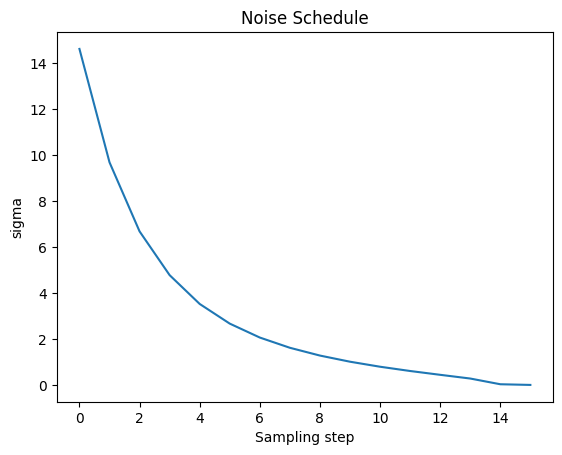

In [33]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

The sigma is the amount of noise added to the latet representation. Lets visualize what this looks like by adding a bit of **noise to our encoded image and then decoding the noised version**.


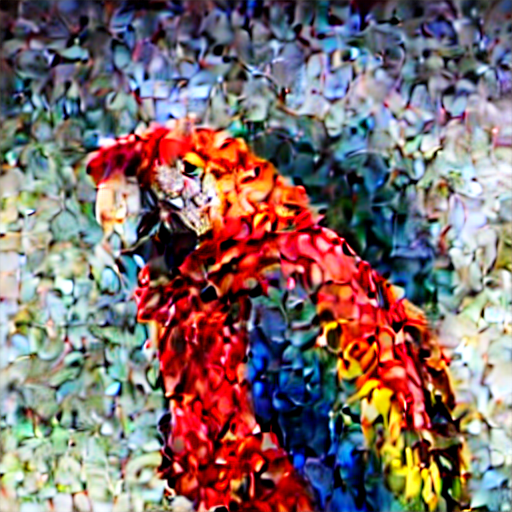

In [36]:
# Creating some random noise (noise is same shape as the latent representation)
noise = torch.randn_like(encoded)

sampling_step = 10 # equivalent to step 10 out of 15 in the scheduler above 
# playaround with the above 

# Takes in the encoder, noise, and the timestep (t)
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps = torch.tensor([scheduler.timesteps[sampling_step]]))

# Display the image
latents_to_pil(encoded_and_noised.float())[0] 


The main implementation of the above, 

`noisy_sample = original_samples * noise * sigma`

If we want to start from random noise instead of a noised image, we need to scale it by the largest sigma value used during training, ~14 in this case. And before these noisy latents are fed to the model they are scaled again in the so-called pre-conditioning step: `latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)` (now handled by `latent_model_input = scheduler.scale_model_input(latent_model_input, t))`. 

### Running a example loop 

Lets use image as a starting point by adding some noise and doing the final denoising steps in the loop with a new prompt. 


0it [00:00, ?it/s]

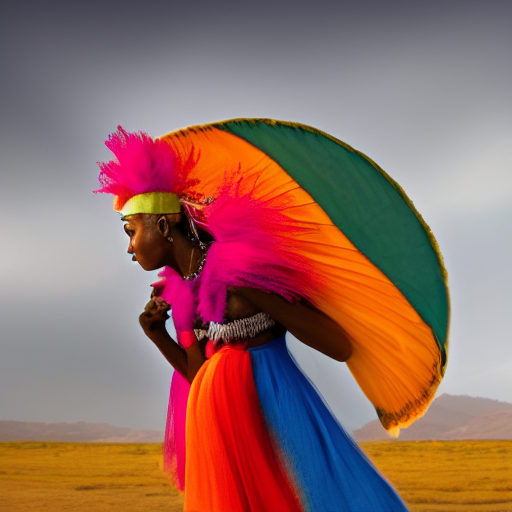

In [37]:
# Settings (same as before except for the new prompt)
prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

The above is the img2img pipeline, but we need to look into how we add the text embedding pipeline too. 

## Exploring the text -> text embedding pipeline 

We use a text encoder model to turn out text into a set of "embeddings" which are fed into  the diffusion model as conditioning. 

In [38]:
# Our example text prompt 
prompt = "A picture of a puppy"


First lets begin with tokenization 

In [41]:
# Turn the tetx into a sequence of discrete tokens 
text_input = tokenizer(prompt , padding = "max_length" , max_length = tokenizer.model_max_length , truncation = True , 
                       return_tensors = "pt")
text_input['input_ids'][0]

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [42]:
# See the individual tokens
for t in text_input['input_ids'][0][:8]:
  print(t , tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


After the sentence ends, its all `<end of text>` tokens